In [48]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [49]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [50]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [51]:
anchor = tf.data.Dataset.list_files('/content/anchor/*.jpg')
len(anchor)

103

In [52]:
positive = tf.data.Dataset.list_files('/content/positive/*.jpg')
len(positive)

103

In [53]:
negative = tf.data.Dataset.list_files('/content/n/*.jpg')
len(negatives)

103

In [54]:
dir_test = anchor.as_numpy_iterator()

In [55]:
print(dir_test.next())

b'/content/anchor/Image_3.jpg'


## 3.2 Preprocessing - Scale and Resize

In [56]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [57]:
img = preprocess('/content/anchor/Image_35.jpg')

In [58]:
img.numpy().max()

1.0

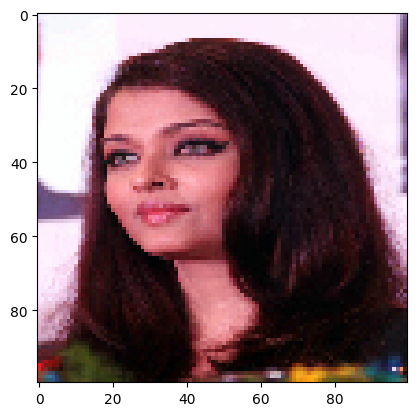

In [59]:
plt.imshow(img)

In [60]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [61]:
samples = data.as_numpy_iterator()

In [62]:
example = samples.next()

In [63]:
example

(b'/content/anchor/138.jpg', b'/content/positive/69.jpg', 1.0)

In [64]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [65]:
res = preprocess_twin(*example)

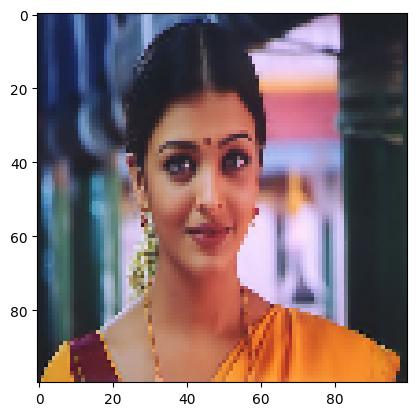

In [66]:
plt.imshow(res[1])

In [67]:
res[2]

1.0

In [68]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [69]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [70]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [71]:
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
l1 = L1Dist()

In [72]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [73]:
siamese_model = make_siamese_model()

In [74]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [75]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [76]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [78]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [80]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [88]:
from tensorflow.keras.metrics import Precision, Recall,Accuracy
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()
        a=Accuracy()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            a.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy(), a.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [89]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
9/9 [==============================] - 3s 312ms/step
0.00020607232 1.0 1.0 0.020833334

 Epoch 2/50
9/9 [==============================] - 3s 341ms/step
0.00016592619 1.0 1.0 0.0

 Epoch 3/50
9/9 [==============================] - 3s 303ms/step
0.00024016248 1.0 1.0 0.013888889

 Epoch 4/50
9/9 [==============================] - 3s 316ms/step
0.00032991546 1.0 1.0 0.013888889

 Epoch 5/50
9/9 [==============================] - 3s 341ms/step
0.00023926105 1.0 1.0 0.013888889

 Epoch 6/50
9/9 [==============================] - 3s 313ms/step
0.00024035544 1.0 1.0 0.020833334

 Epoch 7/50
9/9 [==============================] - 3s 315ms/step
0.0002498933 1.0 1.0 0.013888889

 Epoch 8/50
9/9 [==============================] - 3s 344ms/step
0.00018742608 1.0 1.0 0.013888889

 Epoch 9/50
9/9 [==============================] - 3s 326ms/step
0.00033044943 1.0 1.0 0.013888889

 Epoch 10/50
9/9 [==============================] - 3s 300ms/step
0.00029229335 1.0 1.0 0.0069444445

 Epoch

# 6. Evaluate Model

In [103]:
from tensorflow.keras.metrics import Precision, Recall,Accuracy
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 34ms/step


[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]

In [104]:
((y_true==np.array([1 if prediction > 0.5 else 0 for prediction in y_hat ])).sum())/y_true.shape[0]

1.0

In [105]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object

1.0

In [106]:
m = Precision()


m.update_state(y_true, y_hat)


m.result().numpy()


1.0

In [109]:
r = Recall()
p = Precision()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)
    print(((y_true==np.array([1 if prediction > 0.5 else 0 for prediction in yhat ])).sum())/y_true.shape[0])

print(r.result().numpy(), p.result().numpy())


1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 31ms/step
1.0
1.0 1.0


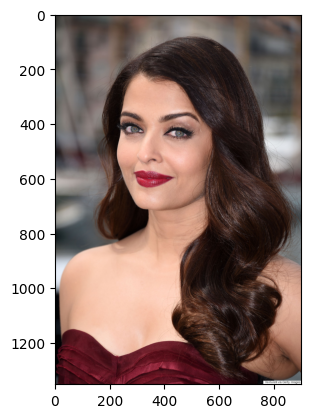

In [158]:
import matplotlib.image as mpimg
img1 = mpimg.imread('/content/test_anchor/155.jpg')
plt.imshow(img1)

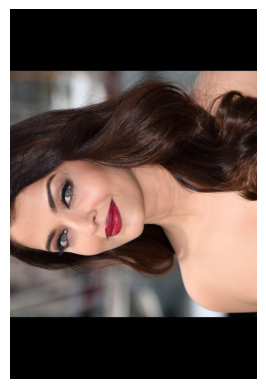

In [164]:
from PIL import Image

# Giving The Original image Directory
# Specified
Original_Image = Image.open("/content/test_anchor/155.jpg")

# Rotate Image By 180 Degree


# This is Alternative Syntax To Rotate
# The Image
rotated_image2 = Original_Image.rotate(90)
# This Will Rotate Image By 60 Degree



plt.imshow(rotated_image2)
plt.axis('off')  # Hide axis
plt.show()


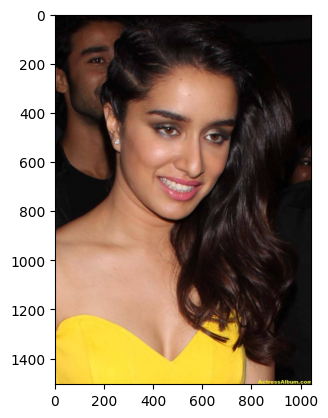

In [160]:
img3 = mpimg.imread('/content/test_negative/Image_3.jpg')
plt.imshow(img3)

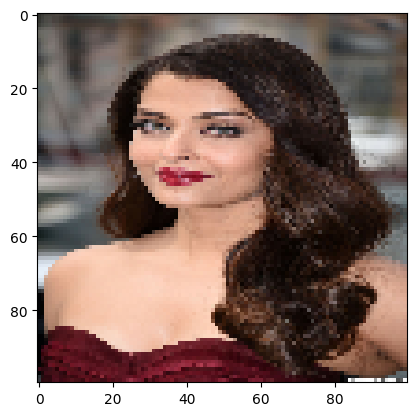

In [161]:
test_img1 = preprocess('/content/test_anchor/155.jpg') #base image
plt.imshow(test_img1)

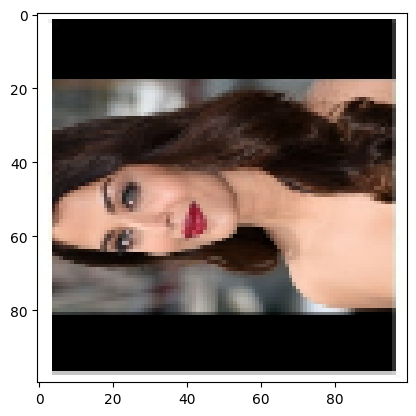

In [162]:
test_img2 = preprocess('/content/test_positive/a.jpg') #rotated image to be verifed
plt.imshow(test_img2)

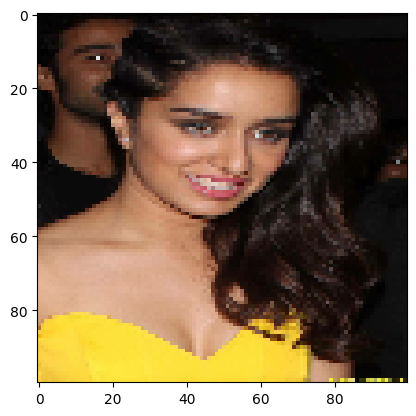

In [163]:
test_img3 = preprocess('/content/test_negative/Image_3.jpg') #negative image to be verified
plt.imshow(test_img3)
a=np.array(test_img1)
b=np.array(test_img2)

In [165]:
test_anchor = tf.data.Dataset.list_files('/content/test_anchor/*.jpg')  # contains test_img1 as shown above
test_positive = tf.data.Dataset.list_files('/content/test_positive/*.jpg') #contains test_img2 as shown above
test_negative = tf.data.Dataset.list_files('/content/test_negative/*.jpg') #contains test_img3 as shown above

In [167]:
dir_test = test_anchor.as_numpy_iterator()
print(dir_test.next())  # should be same as test_img1 path

b'/content/test_anchor/155.jpg'


In [168]:
dir_test = test_positive.as_numpy_iterator()
print(dir_test.next())  # should be same as test_img2 path

b'/content/test_positive/a.jpg'


In [169]:
dir_test = test_negative.as_numpy_iterator()
print(dir_test.next())  # should be same as test_img3 path

b'/content/test_negative/Image_3.jpg'


In [170]:
test_positives = tf.data.Dataset.zip((test_anchor, test_positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
test_negatives = tf.data.Dataset.zip((test_anchor, test_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
test_data = test_positives.concatenate(test_negatives)

In [171]:
test_data = test_data.map(preprocess_twin)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [173]:
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    accuracy=(((y_true==np.array([1 if prediction > 0.5 else 0 for prediction in yhat ])).sum())/y_true.shape[0])
print(accuracy)


1/1 [==============================] - 0s 50ms/step
1.0
